<a href="https://colab.research.google.com/github/TerryTian21/DataScience/blob/main/Notebooks/Sales_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting

**Aim**: Utilizing department store sales data to forecast future sales.

**DataSet**: Obtained from [Data.World](https://data.world/retail/department-store-sales)


## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
url = "https://github.com/TerryTian21/DataScience/raw/main/Data/retail-trade-report-department-stores.xls"
df = pd.read_excel(url)
df.head()

,Period,Value (in millions)
0,Jan-1992,10306
1,Feb-1992,11251
2,Mar-1992,12917
3,Apr-1992,13461
4,May-1992,14286


In [ ]:
df.describe()

,Value (in millions)
count,298.000000
mean,16634.006711
std,4523.569917
min,10221.000000
25%,13958.750000
50%,15819.500000
75%,17547.750000
max,34317.000000


## EDA


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Period               298 non-null    object
 1   Value (in millions)  298 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.8+ KB


In [ ]:
df["Period"] = pd.to_datetime(df["Period"])

<ipython-input-5-47a9b6782189>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Period"] = pd.to_datetime(df["Period"])


In [ ]:
df = df.sort_values(by="Period", ascending=True)

In [ ]:
df = df.set_index('Period')
df = df.rename(columns={"Value (in millions)": "sales"})

In [ ]:
df.head(15)

,sales
Period,
1992-01-01,10306
1992-02-01,11251
1992-03-01,12917
1992-04-01,13461
1992-05-01,14286
1992-06-01,13354
1992-07-01,13101
1992-08-01,14783
1992-09-01,13323


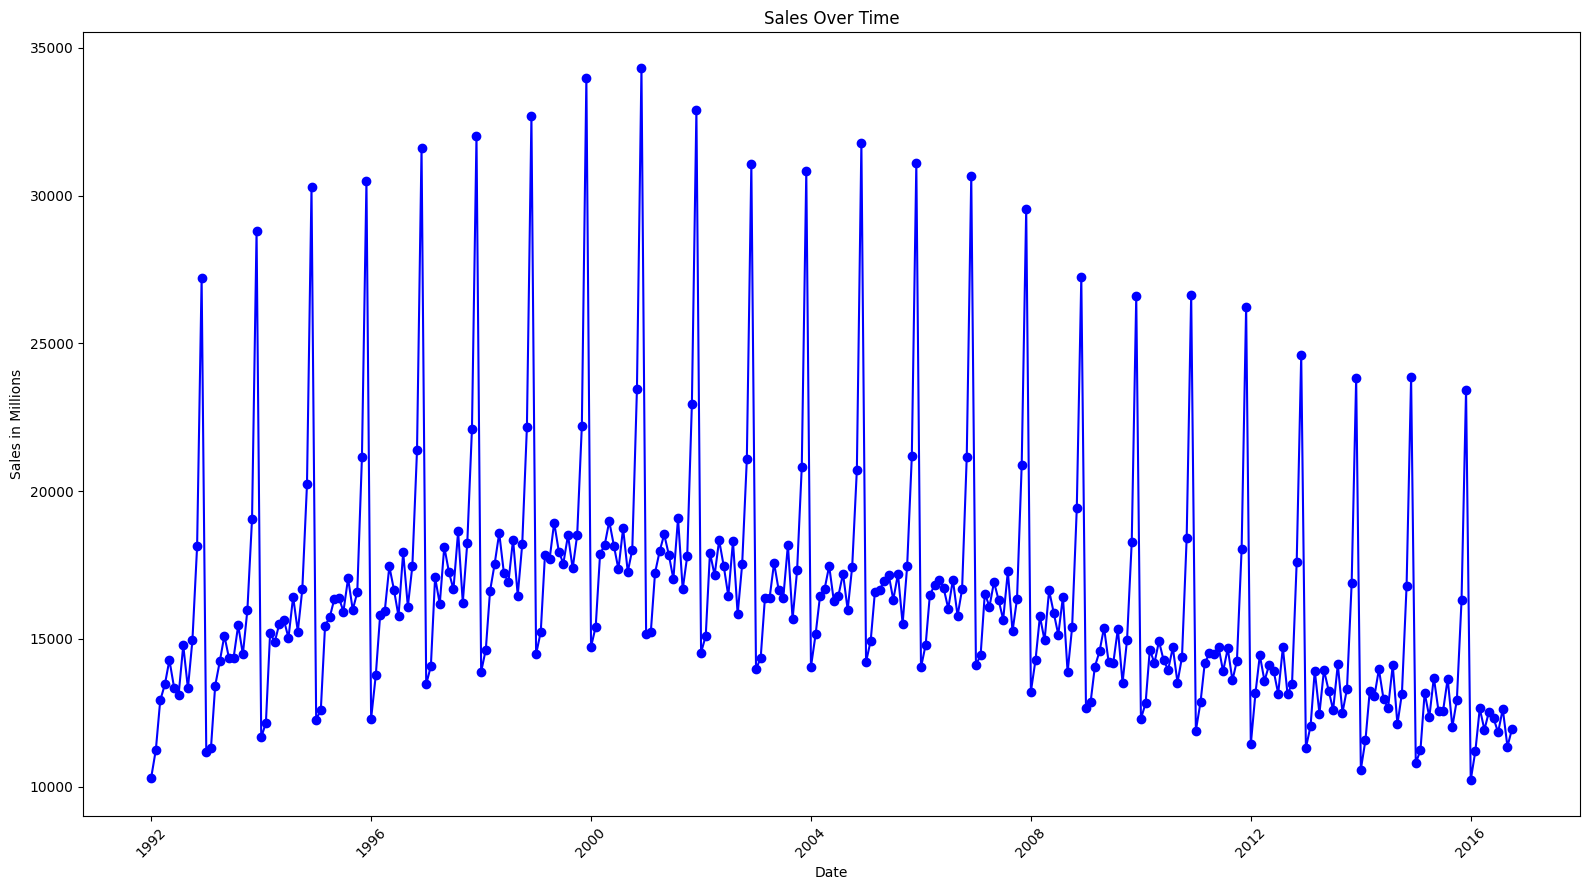

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(df.index, df["sales"], marker="o", linestyle='-', color="blue")
plt.title("Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales in Millions")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

When choosing the type of decomposition to perform, we can either choose "additive" or "multiplicative" depending on the time-series data. For additive models,the Seasonal Variation should be relatively constant over time.

Additive : $x_i$ = Trend + Seasonal + Random
Multiplicative : $x_i$ = Trend * Seasonal * Random


In [ ]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(df["sales"], model="additive", period=12)

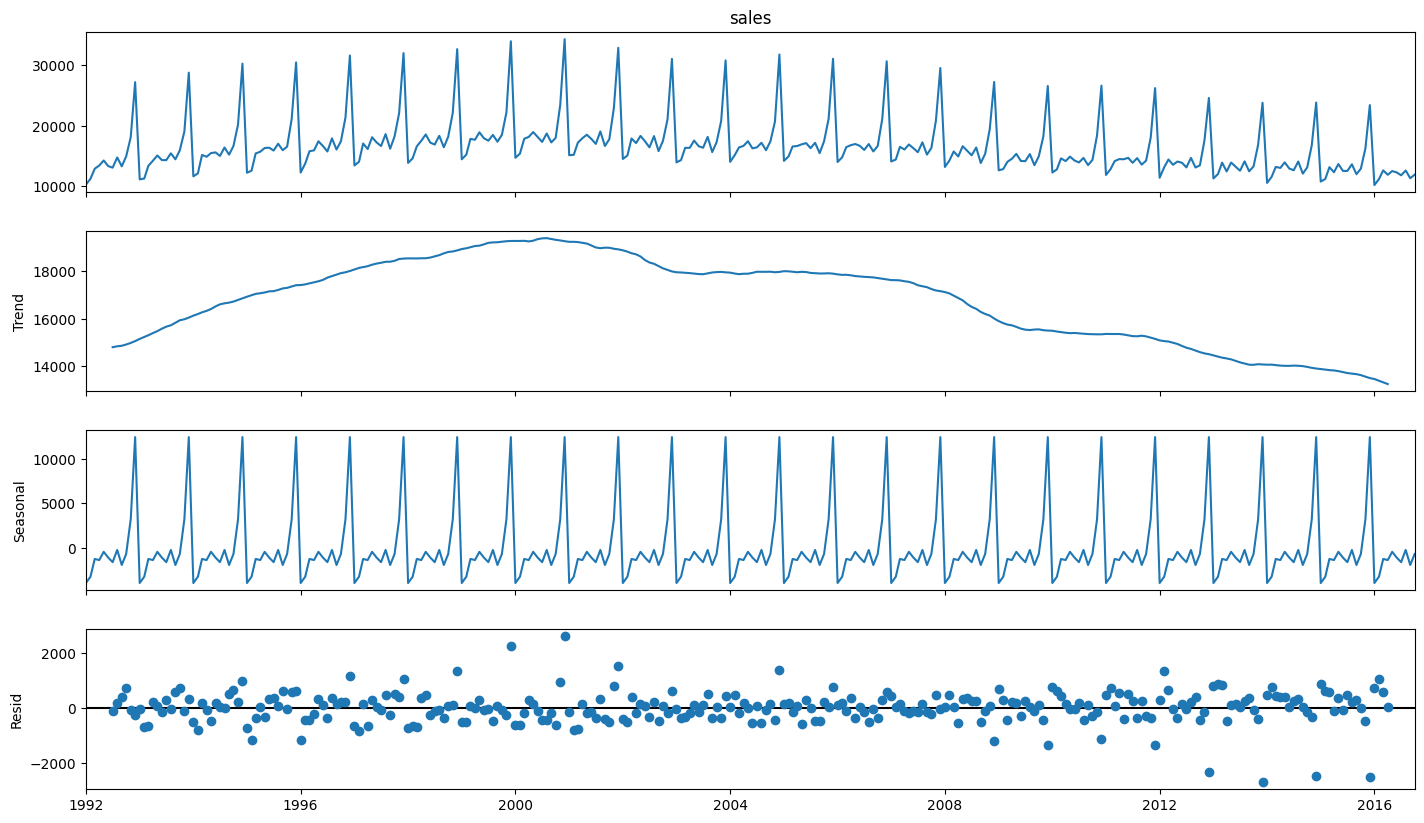

In [ ]:
fig = decomposition.plot()
fig.set_size_inches(16,9)
plt.show()

Observing the decomposed time-series, we would expect an overall downward trend in the future, with the same seasonal variance.

## Hyperparameters Tunning and Model Selection

In [ ]:
from itertools import product
y = df["sales"]

p = d = q = list(range(0,2))
order = list(product(p, d, q))
seasonal_order = list(product(p,d,q,[12]))

In [ ]:
order

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [15]:
seasonal_order

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

`sm.tsa.statespace.sarimax.SARIMAX` has optional parameter which controls the deterministic trend polynomial $A(t)$.
- "c" : Constant
- "t" : Linear
- "ct" : Both

In [17]:
trend = ["n", "c", "t", "ct"]

In [18]:
simple_difference = ["true", "false"]

Perform Grid Search utilizing the SARIMAX Model and evaluate on
- Akaike Information Criterion (AIC) : Measures tradeoff between goodness of fit and model complexity with lower values indicating better model

In [25]:
import warnings
from tqdm.auto import tqdm

warnings.filterwarnings('ignore')

results = {
    "order" : [],
    "seasonal_order" : [],
    "trend" : [],
    "simple_difference": [],
    "aic": []
}

for o in tqdm(order, desc="Hyperparam Tuning"):
  for so in seasonal_order:
    for t in trend:
      for sd in simple_difference:
        try:
            model = sm.tsa.SARIMAX(y, order=o, seasonal_order=so, trend=t, simple_difference=sd)
            res = model.fit(disp=False)

            results["order"].append(o)
            results["seasonal_order"].append(so)
            results["trend"].append(t)
            results["simple_difference"].append(sd)
            results["aic"].append(res.aic)
        except Exception as e:
          print(f"Error: {e}")
          continue

Hyperparam Tuning:   0%|          | 0/8 [00:00<?, ?it/s]

Error: LU decomposition error.
Error: LU decomposition error.
Error: LU decomposition error.
Error: LU decomposition error.
Error: LU decomposition error.
Error: LU decomposition error.


In [29]:
best_aic_idx = results["aic"].index(min(results["aic"]))
print(results["aic"][best_aic_idx])

12.0


In [28]:
best_order = results["order"][best_aic_idx]
best_seasonal_order = results["seasonal_order"][best_aic_idx]
best_trend = results["trend"][best_aic_idx]
best_simple_difference = results["simple_difference"][best_aic_idx]

In [30]:
best_order

(1, 0, 1)

In [31]:
best_seasonal_order

(1, 0, 1, 12)

In [32]:
best_trend

't'

In [33]:
best_simple_difference

'true'

## Fit Model With Best Parameters and Make Predictions

Perform Cross-Validation

In [138]:
train = int(len(y) * 0.8)

training_data = y[:train]
train_model = model = sm.tsa.SARIMAX(training_data, order=best_order, seasonal_order=best_seasonal_order)
train_result = train_model.fit()

In [139]:
print(train_result.params)

ar.L1       9.996382e-01
ma.L1      -8.341246e-01
ar.S.L12    9.994685e-01
ma.S.L12   -9.493685e-01
sigma2      1.188529e+07
dtype: float64


In [140]:
fcast = train_result.forecast()

# Compute Error
true = y.reindex(fcast.index)
error = true - fcast

# Print Results
print(pd.concat([true.rename('true'),
                 fcast.rename('forecast'),
                 error.rename('error')], axis=1))


             true      forecast       error
2011-11-01  18035  18548.626555 -513.626555


In [146]:
# Loop through data and perform cross-validation while tuning the parameters

nforecasts = 10
forecasts = {}

# Get number of initial traning observations
n_obs = len(y)
n_init_train = int(n_obs * 0.8)

# Create mdoel for initial training sample
train_data = y[:n_init_train]
model = sm.tsa.SARIMAX(train_data, order=best_order, seasonal_order=best_seasonal_order)
res = model.fit()

# Save initial forecast
forecasts[train_data.index[-1]] = res.forecast(steps=nforecasts)

# Step through rest of data
for i in range(n_init_train, n_obs):

  new_obs = y[i: i+1]
  res = res.append(new_obs, refit=True)

  forecasts[new_obs.index[0]] = res.forecast(steps=nforecasts)

# Combine Forecasts
forecasts = pd.concat(forecasts, axis=1)


In [161]:
forecasts.head(11)

,2011-10-01,2011-11-01,2011-12-01,2012-01-01,2012-02-01,2012-03-01,2012-04-01,2012-05-01,2012-06-01,2012-07-01,...,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01
2011-11-01,18548.626555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-01,27984.635840,27899.824972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01,11357.670723,11272.884686,10999.209630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-01,11991.060324,11906.336794,11632.863094,11703.880425,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-01,13949.229090,13864.568056,13591.295675,13662.259349,13904.034281,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-01,14005.863093,13921.264545,13648.193448,13719.103472,13960.697696,14050.157223,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-01,14845.098358,14760.562285,14487.692436,14558.548821,14799.962368,14889.355634,14810.977174,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-06-01,14216.301709,14131.828099,13859.159462,13929.962218,14171.195119,14260.522136,14182.201293,14066.031758,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-07-01,13710.101008,13625.689850,13353.222390,13423.971524,13665.023812,13754.284591,13676.021355,13559.936685,13533.826341,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-08-01,15007.338086,14922.989368,14650.723049,14721.418572,14962.290278,15051.484830,14973.279191,14857.279370,14831.188002,14766.953443,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [148]:
forecast_errors = forecasts.apply(lambda column : y - column).reindex(forecasts.index)
forecast_errors.head()

,2011-10-01,2011-11-01,2011-12-01,2012-01-01,2012-02-01,2012-03-01,2012-04-01,2012-05-01,2012-06-01,2012-07-01,...,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01
2011-11-01,-513.626555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-01,-1741.635840,-1656.824972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01,70.329277,155.115314,428.790370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-01,1173.939676,1258.663206,1532.136906,1461.119575,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-01,495.770910,580.431944,853.704325,782.740651,540.965719,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [156]:
# Reindex forecasts by horizon rather than date

def flatten(column):
  return column.dropna().reset_index(drop=True)

flattened = forecast_errors.apply(flatten)
flattened.index = (flattened.index + 1).rename('horizon')
flattened

,2011-10-01,2011-11-01,2011-12-01,2012-01-01,2012-02-01,2012-03-01,2012-04-01,2012-05-01,2012-06-01,2012-07-01,...,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01
horizon,,,,,,,,,,,,,,,,,,,,,
1,-513.626555,-1656.824972,428.790370,1461.119575,540.965719,-474.157223,-702.977174,-158.031758,-388.826341,-56.953443,...,880.490431,277.558806,-353.868172,-575.067099,-48.741190,-28.841544,-551.582465,-74.391788,-643.873257,NaN
2,-1741.635840,155.115314,1532.136906,782.740651,-384.697696,-781.355634,-274.201293,-414.936685,-121.188002,4.792314,...,423.268939,-307.952917,-633.590900,-143.831098,-36.900179,-556.350617,-165.576014,-656.170837,NaN,NaN
3,70.329277,1258.663206,853.704325,-143.103472,-691.962368,-352.522136,-531.021355,-147.279370,-59.395761,-916.733237,...,-162.329738,-587.702869,-202.320386,-131.934259,-564.404538,-170.341385,-747.302019,NaN,NaN,NaN
4,1173.939676,580.431944,-72.193448,-450.548821,-263.195119,-609.284591,-263.279191,-85.468157,-980.874836,-634.334095,...,-442.166627,-156.459573,-190.389041,-659.382803,-178.390594,-752.064610,NaN,NaN,NaN,NaN
5,495.770910,-345.264545,-379.692436,-21.962218,-520.023812,-341.484830,-201.383143,-1006.928263,-698.429227,-2997.552798,...,-11.010248,-144.555440,-717.803088,-273.313056,-760.109107,NaN,NaN,NaN,NaN,NaN
6,-429.863093,-652.562285,48.840538,-278.971524,-252.290278,-279.531196,-1122.758431,-724.463689,-3061.601471,213.065149,...,0.806987,-671.996692,-331.698850,-854.975779,NaN,NaN,NaN,NaN,NaN,NaN
7,-737.098358,-223.828099,-208.222390,-11.418572,-190.402859,-1200.848908,-840.209053,-3087.616971,148.999729,244.620373,...,-526.721145,-285.919655,-913.327091,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,-308.301709,-480.689850,59.276951,50.288297,-1111.786773,-918.241964,-3203.277547,122.971784,180.599850,209.857276,...,-140.730968,-867.575089,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,-565.101008,-212.989368,120.930218,-871.276136,-829.246020,-3281.252902,7.225783,154.590229,145.881643,-1241.860196,...,-722.473243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We would expect the predictions to become less accurate the further out we forecast, and this result is refelcted by the increasing RMSE

In [153]:
# Compute RMSE for each Horizon

rmse = (flattened**2).mean(axis=1)**0.5

rmse

horizom
1     867.160392
2     895.565606
3     866.667871
4     845.980946
5     844.171987
6     861.596832
7     892.479620
8     904.261603
9     920.336386
10    901.313201
dtype: float64

With our model, let's make some predictions.

In [160]:
predictions = res.get_forecast(steps=36).summary_frame()

In [143]:
y.index[-1]

Timestamp('2016-10-01 00:00:00')

In [157]:
predictions = model.fit()

In [162]:
preds = predictions.rename(columns={"mean": "sales"})
preds

sales,sales,mean_se,mean_ci_lower,mean_ci_upper
2016-11-01,16283.823223,3461.757751,9498.902708,23068.743739
2016-12-01,25103.056907,3508.732040,18226.068476,31980.045337
2017-01-01,9365.806174,3554.111028,2399.876562,16331.735787
2017-02-01,10087.094225,3599.739852,3031.733762,17142.454687
2017-03-01,11956.883010,3644.748232,4813.307743,19100.458277
2017-04-01,11785.671776,3689.158901,4555.053197,19016.290354
2017-05-01,12659.916645,3732.993214,5343.384392,19976.448898
2017-06-01,12026.300016,3776.271264,4624.944343,19427.655689
2017-07-01,11543.566128,3819.011985,4058.440181,19028.692075
2017-08-01,12831.883670,3861.233242,5264.005579,20399.761761


Visualize Predictions

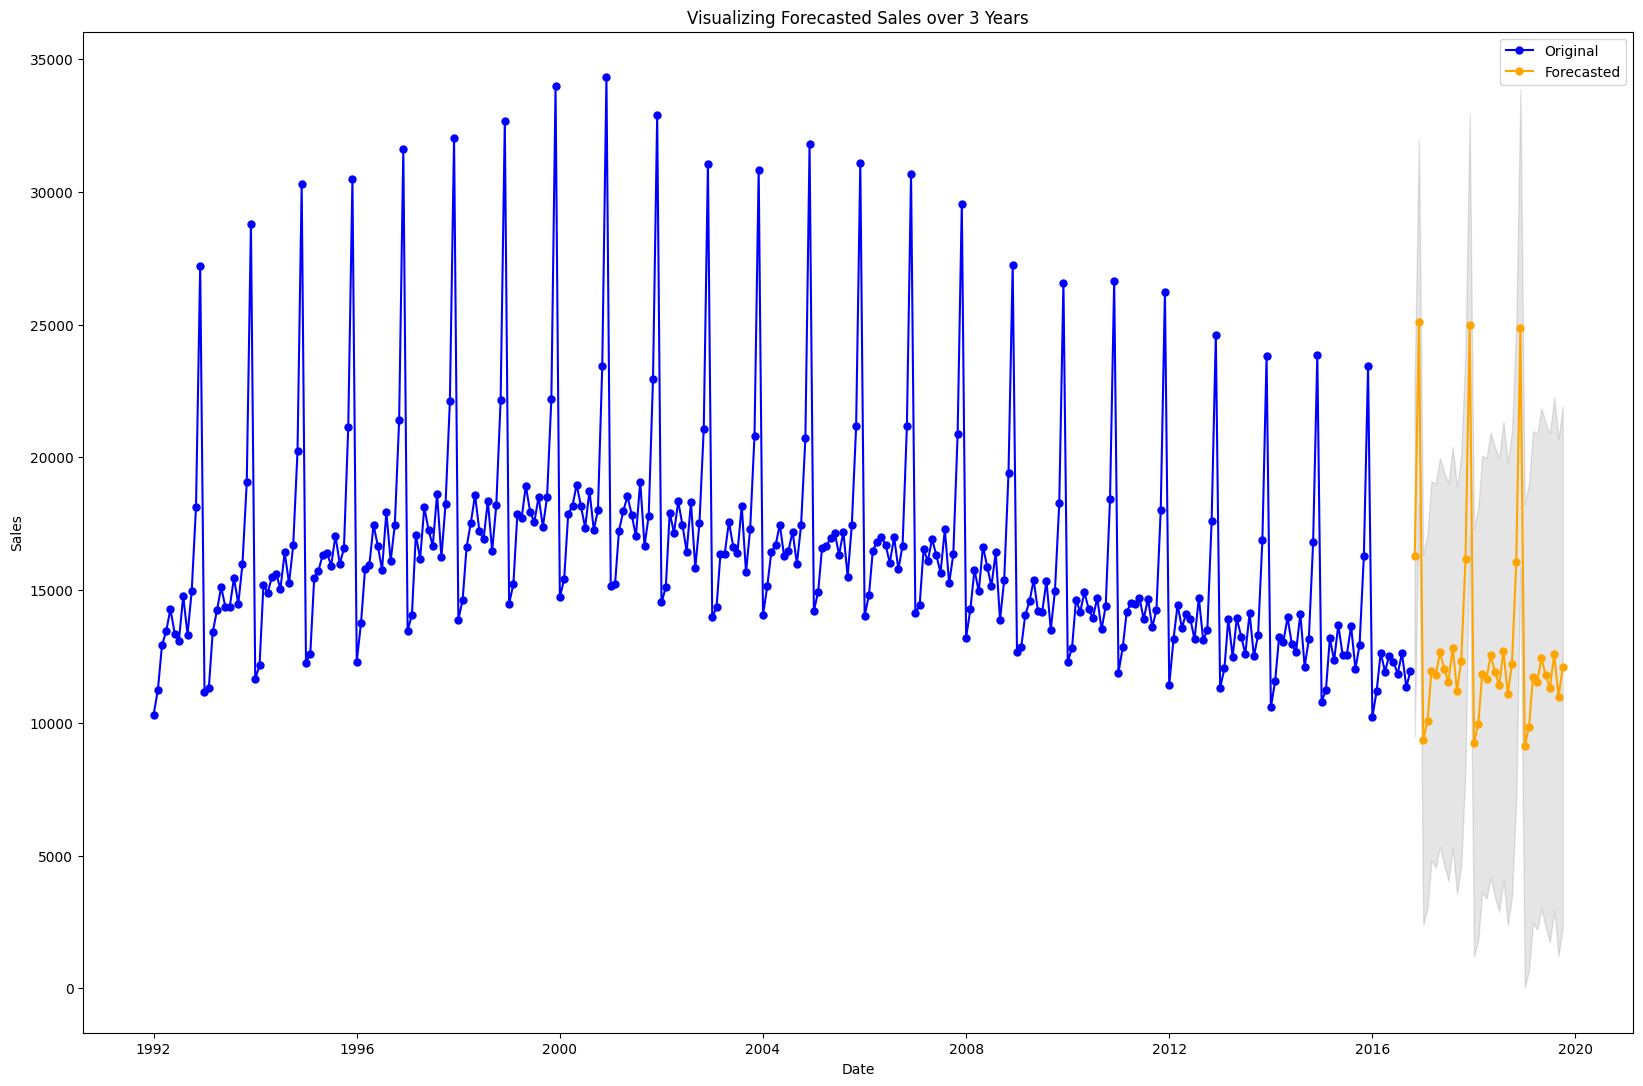

In [163]:
plt.figure(figsize=(20,13))
plt.plot(df.index, df["sales"], color="blue", markersize=5, marker="o", linestyle="-", label="Original")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Visualizing Forecasted Sales over 3 Years")

# Plot the Forecasted Data
plt.plot(preds.index, preds["sales"], color="orange", markersize=5, marker="o", linestyle="-", label="Forecasted")
plt.fill_between(preds.index, preds["mean_ci_lower"], preds["mean_ci_upper"], color="k", alpha=0.1)

plt.legend()
plt.show()

## Utilize Prophet for Time Series Visualizations

In [118]:
from prophet import Prophet

new_df = df.copy().resample("MS").sum().reset_index().rename(columns={"Period": "ds", "sales": "y"})

new_df

,ds,y
0,1992-01-01,10306
1,1992-02-01,11251
2,1992-03-01,12917
3,1992-04-01,13461
4,1992-05-01,14286
...,...,...
293,2016-06-01,12308
294,2016-07-01,11836
295,2016-08-01,12628
296,2016-09-01,11355


In [119]:
model = Prophet(growth="linear", yearly_seasonality=True, seasonality_mode="additive", interval_width=0.95)

In [120]:
model.fit(new_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpftdfox6t/g2l92hft.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpftdfox6t/8xq5k945.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38850', 'data', 'file=/tmp/tmpftdfox6t/g2l92hft.json', 'init=/tmp/tmpftdfox6t/8xq5k945.json', 'output', 'file=/tmp/tmpftdfox6t/prophet_modelmzuqp_do/prophet_model-20240509204826.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:48:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:48:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [121]:
# Since we included holidays the periods will be in days
future_dates = model.make_future_dataframe(periods=(365*3))

# Convert the dates back to the start of each month
future_dates.resample("MS", on="ds").sum().reset_index()

,ds
0,1992-01-01
1,1992-02-01
2,1992-03-01
3,1992-04-01
4,1992-05-01
...,...
329,2019-06-01
330,2019-07-01
331,2019-08-01
332,2019-09-01


In [128]:
forecast = model.predict(future_dates)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1992-01-01,14678.787897,9295.487660,11846.523296,14678.787897,14678.787897,-4074.591911,-4074.591911,-4074.591911,-4074.591911,-4074.591911,-4074.591911,0.0,0.0,0.0,10604.195986
1,1992-02-01,14738.080248,10333.184997,12947.507295,14738.080248,14738.080248,-3084.620061,-3084.620061,-3084.620061,-3084.620061,-3084.620061,-3084.620061,0.0,0.0,0.0,11653.460187
2,1992-03-01,14793.547286,12243.447210,14734.369161,14793.547286,14793.547286,-1300.879564,-1300.879564,-1300.879564,-1300.879564,-1300.879564,-1300.879564,0.0,0.0,0.0,13492.667721
3,1992-04-01,14852.839636,12249.148047,14631.594092,14852.839636,14852.839636,-1397.928540,-1397.928540,-1397.928540,-1397.928540,-1397.928540,-1397.928540,0.0,0.0,0.0,13454.911096
4,1992-05-01,14910.219331,13298.165365,15705.446595,14910.219331,14910.219331,-415.888416,-415.888416,-415.888416,-415.888416,-415.888416,-415.888416,0.0,0.0,0.0,14494.330914


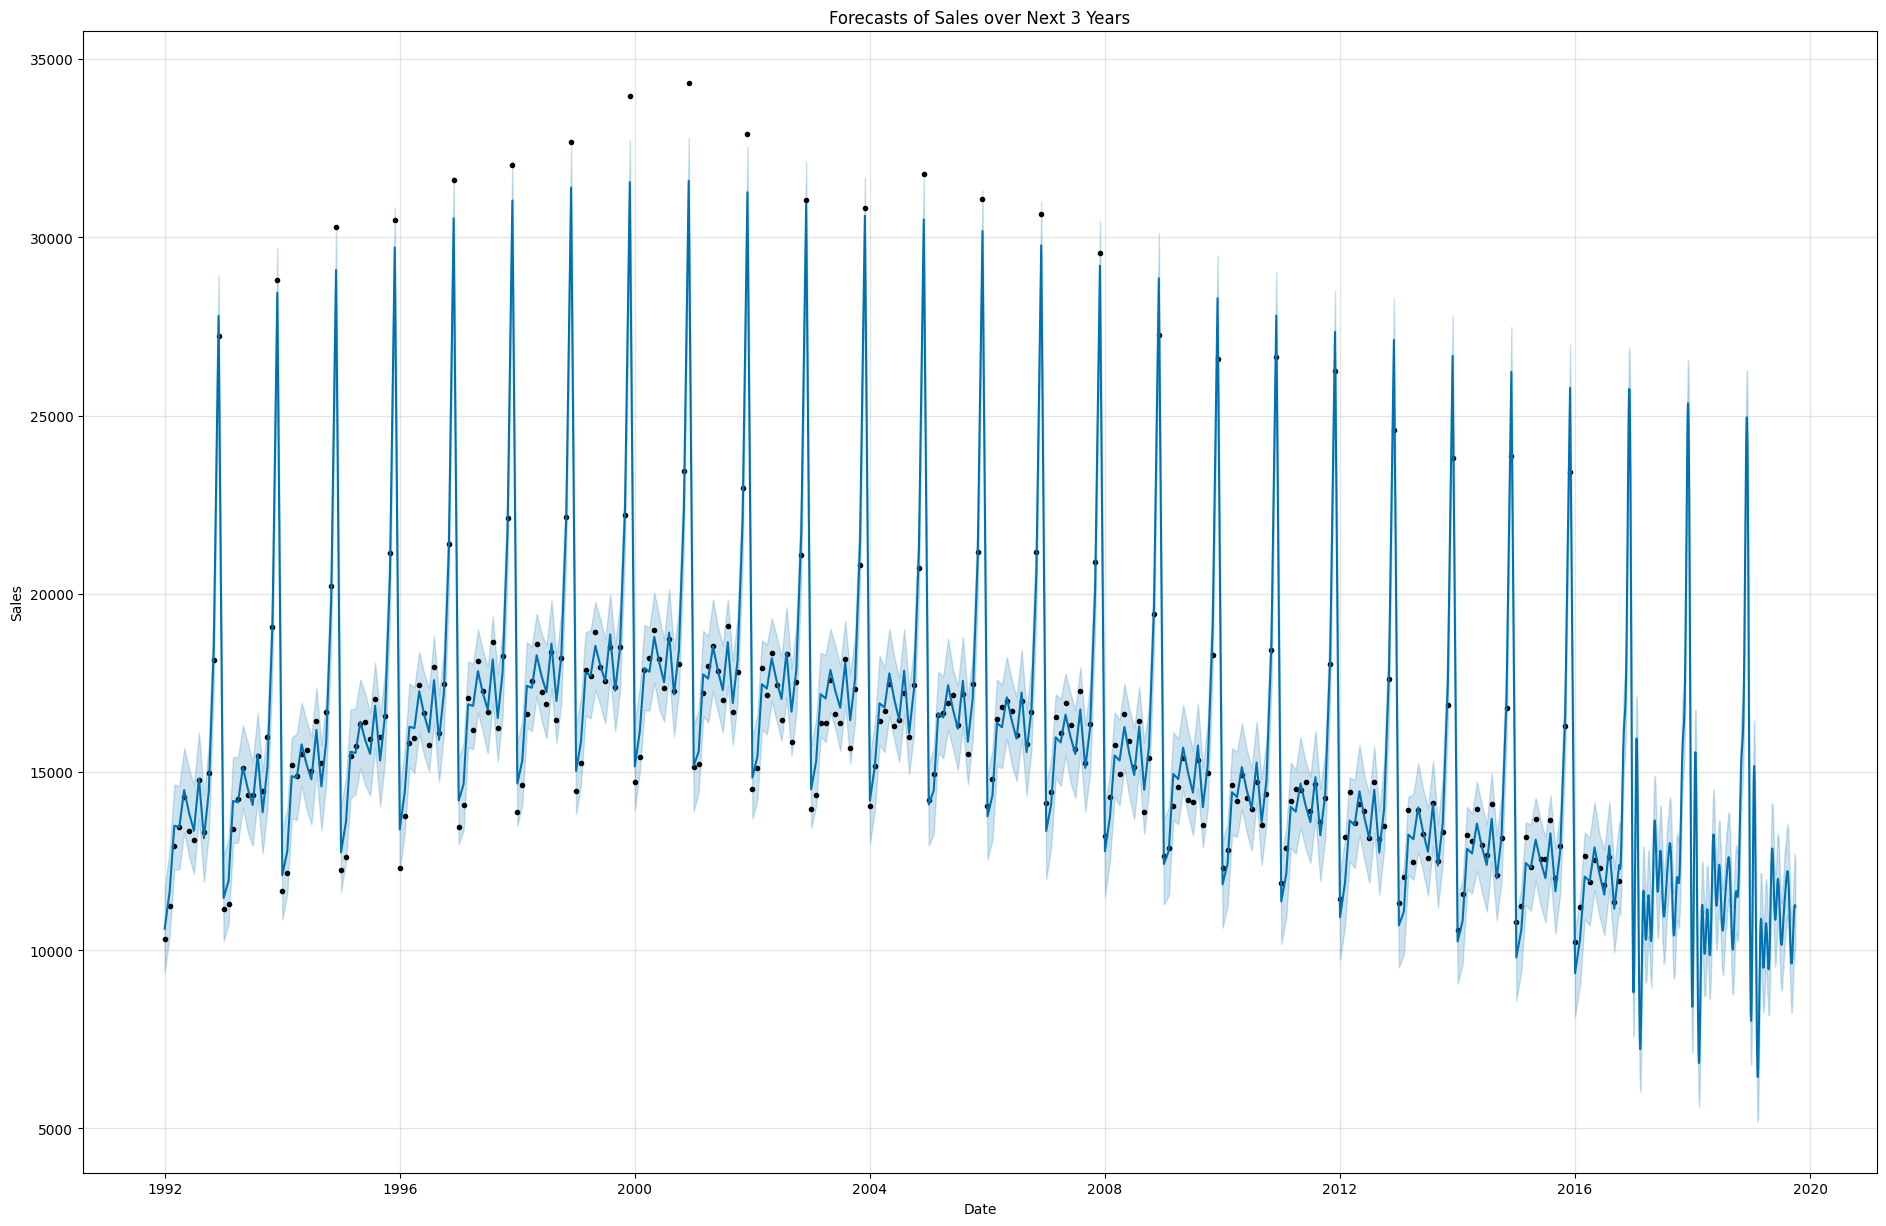

In [127]:
fig = model.plot(forecast, xlabel='Date', ylabel='Sales')
fig.set_size_inches(20,13)
plt.title("Forecasts of Sales over Next 3 Years")
plt.show()

Text(0.5, 1.0, 'Trend')

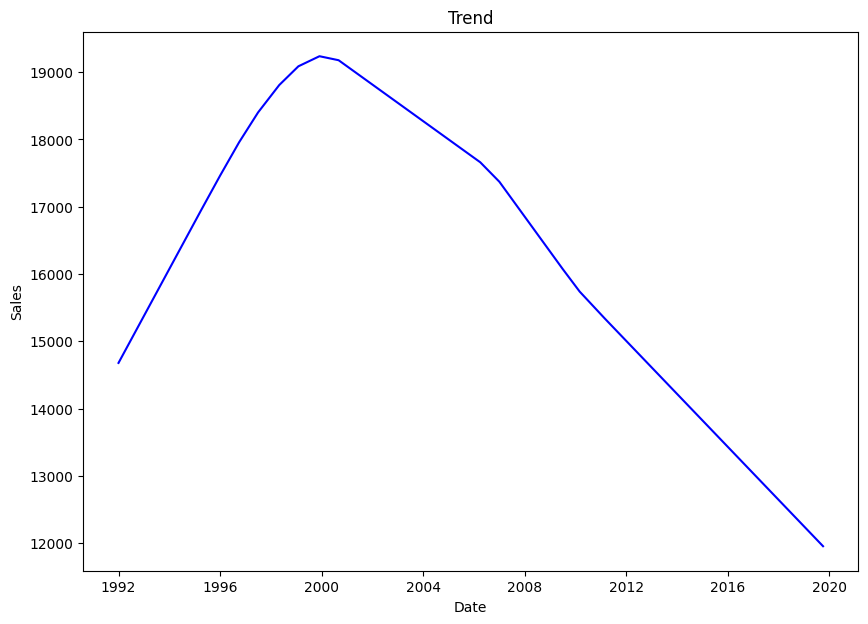

In [131]:
plt.figure(figsize=(10,7))
plt.plot(forecast["ds"], forecast["trend"], color="blue")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Forecasted Trend")

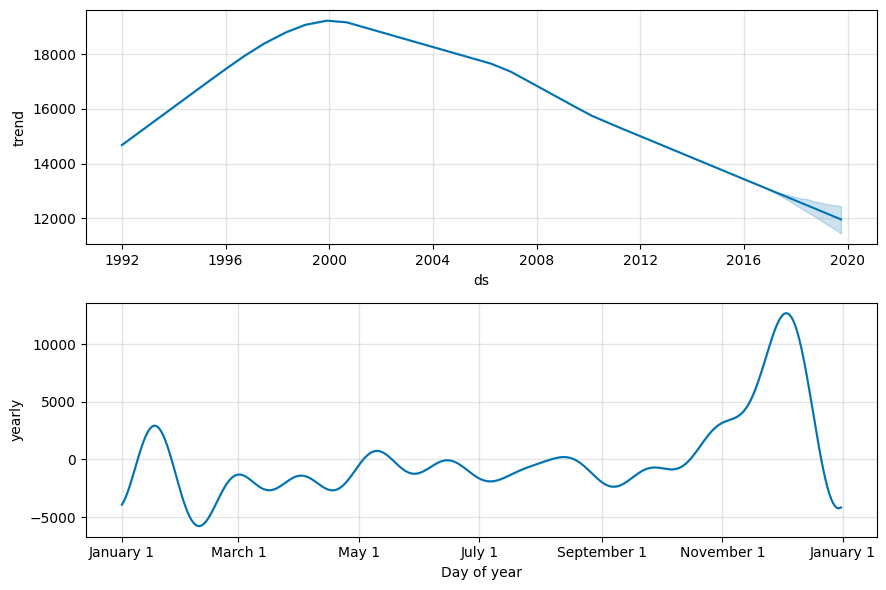

In [133]:
fig = model.plot_components(forecast)

In [135]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)

In [137]:
plot_components_plotly(model, forecast)